# Two-Design-Variable Optimization

In [1]:
# Import settings and constants
import os   # module for interfacing with the underlying operating system
import sys  # module for interacting with the Python interpreter
parent_directory = os.path.join(os.path.dirname(os.getcwd()))
sys.path.append(parent_directory)
from settings import *

# Define name of directory where to save analyses and figures
FIGURES_DIRECTORY_PATH = os.getcwd()
DATA_DIRECTORY_PATH = r"C:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\20_Two-variables_Optimization_of_the_CRM-like_Box_Beam"

# Allow for interactive plots
%matplotlib widget

## Development of the Model

Define constants of the model.

In [2]:
import numpy as np  # module for numerical operations

L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = 0.77e3   # [mm] box beam height
H_S = H/10   # [mm] stiffener height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates

Plot linear buckling optimization history.

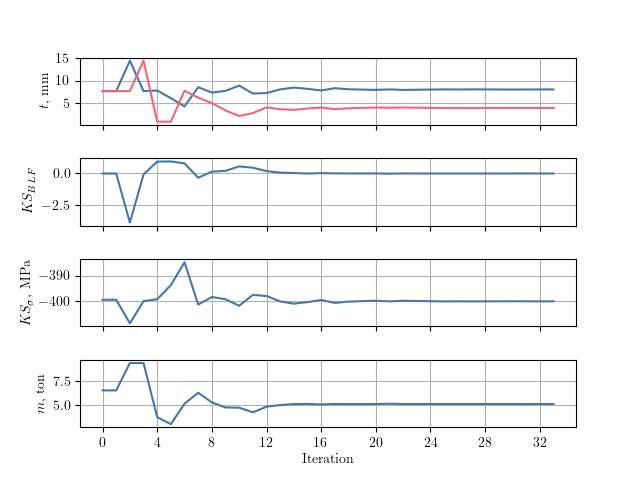

Design variables, constraints and objective at last iteration:
- interp.t_cp: [8.06679384 3.995741  ]
- nastran_solver.ks_buckling: [1.24868317e-05]
- nastran_solver.ks_stress: [-400.04858398]
- nastran_solver.mass: [5.10643595]


In [3]:
# Import helper module
main_directory = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(main_directory)
from resources import optimization_utils

recorder_filename = "sol_105_linear_optimization_tol1e-03.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TwoDesignVariableLinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Print mass reduction and final thickness distribution.

In [4]:
mass_reduction = (histories['nastran_solver.mass'][-1, 0]/histories['nastran_solver.mass'][0, 0] - 1)*100
final_thickness_vector = histories['interp.t_cp'][-1, :]
print("Final thickness vector:")
print(final_thickness_vector)
print(f"Mass reduction: {mass_reduction:.1f} %")

Final thickness vector:
[8.06679384 3.995741  ]
Mass reduction: -21.7 %


Plot critical buckling mode of linearly optimized structure.

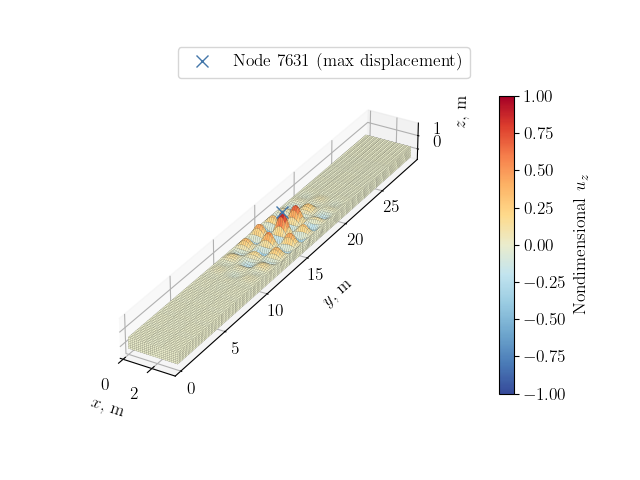

In [5]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file
from resources import plot_utils

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=25)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8,
                     'lines.markersize': 8})
input_name = f"sol_105_linear_optimization_tol1e-03"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
amplification_factor = 1.5  # amplification factor for displacements
clim = [-1, 1]  # colorbar limits
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component="tz", colormap="sunset", length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Plot node where maximum displacement occurs
midspan_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
BBOX_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"TwoDesignVariableLinearOptBucklingMode.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

# Restore default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Plot eigenvalue diagram of linearly optimized structure.

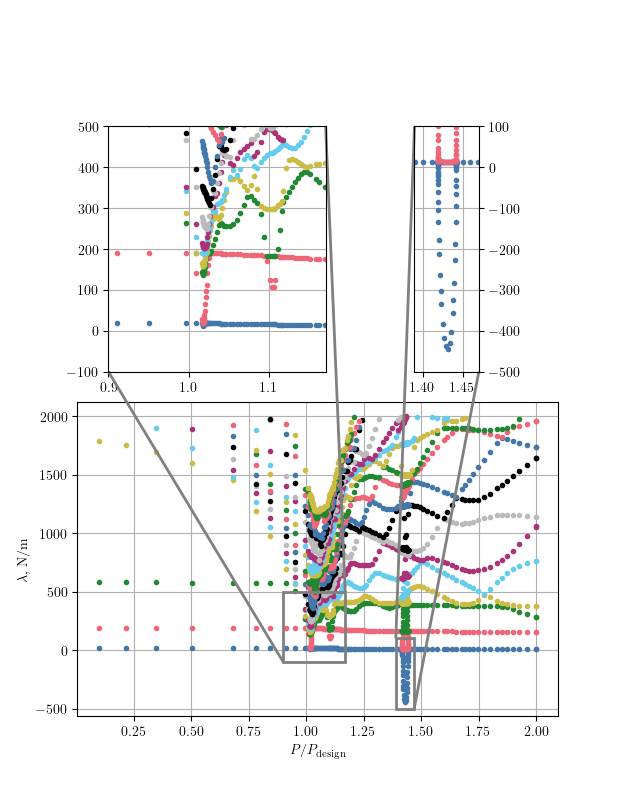

In [6]:
from pyNastran.op2.op2 import read_op2
from resources import pynastran_utils
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

# Initialize dictionaries to store data
sol_106_op2_dict = {}  # dictionary to store op2 files
eigenvalues_dict = {}  # dictionary to store eigenvalues
nondimensional_loads_dict = {}  # dictionary to store nondimensional loads
displacements_dict = {}  # dictionary to store nondimensional displacements

# Make list with root, midspan and tip node IDs
plot_node_ids = [455, midspan_node_id, 14391]

# Recall design load
design_load = 12517.  # [N] design load

# Read eigenvalues, load and displacement histories for linearly optimized structure
NO_EIGENVALUES = 20  # number of eigenvalues of tangent stiffness matrix for each converged icrement
key = "linearly optimized structure"
input_name = "sol_106_linear_optimization_epsu1e-5"
sol_106_op2_dict[key] = read_op2(os.path.join(DATA_DIRECTORY_PATH, input_name) + '.op2', load_geometry=True, debug=None)
eigenvectors_key = next(iter(sol_106_op2_dict[key].eigenvectors))
sequence_starts = np.where(sol_106_op2_dict[key].eigenvectors[eigenvectors_key].lsdvmns == 1)[0]
sequence_ends = np.roll(sequence_starts, -1)
sequence_ends[-1] = len(sol_106_op2_dict[key].eigenvectors[eigenvectors_key].lsdvmns)  # Setting the end of the last sequence to the end of the array
eigenvalues_dict[key] = np.column_stack([
    np.pad(sol_106_op2_dict[key].eigenvectors[eigenvectors_key].eigrs[start:end], (0, NO_EIGENVALUES - (end - start)), mode='constant', constant_values=np.nan)
    for start, end in zip(sequence_starts, sequence_ends)])
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2_dict[key], node_ids=plot_node_ids)
linear_opt_first_subcase_id = next(iter(loads))  # get key of subcase
nondimensional_loads_dict[key] = loads[linear_opt_first_subcase_id][:, Z_COMPONENT_INDEX]/design_load
displacements_dict[key] = displacements

# Create the figure
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*1.3))
fig.subplots_adjust(top=.5)

# Plot eigenvalues vs applied load
plt.plot(nondimensional_loads_dict[key], eigenvalues_dict[key].T*1e3, "o")  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda,\,\mathrm{N/m}$")
plt.xlabel("$P/P_\mathrm{design}$")
plt.grid(True)

# Create the first zoomed inset
x1, x2 = .9, 1.17  # x-interval of interest for the first zoomed inset
y1, y2 = -100, 500  # y-interval of interest for the first zoomed inset
axins1 = zoomed_inset_axes(ax, zoom=3.5, loc="upper left", bbox_to_anchor=(0.05, 1.9), bbox_transform=ax.transAxes)
axins1.plot(nondimensional_loads_dict[key], eigenvalues_dict[key].T * 1e3, "o")
axins1.set_xlim(x1, x2)  # Adjust the limits as needed
axins1.set_ylim(y1, y2)    # Adjust the limits as needed
mark_inset(ax, axins1, loc1=3, loc2=1, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest

# Create the second zoomed inset
x1, x2 = 1.39, 1.47  # x-interval of interest for the second zoomed inset
y1, y2 = -500, 100  # y-interval of interest for the second zoomed inset
axins2 = zoomed_inset_axes(ax, zoom=3.5, loc="upper right", bbox_to_anchor=(.85, 1.9), bbox_transform=ax.transAxes)
axins2.plot(nondimensional_loads_dict[key], eigenvalues_dict[key].T * 1e3, "o")
axins2.set_xlim(x1, x2)  # Adjust the limits based on your region of interest
axins2.set_ylim(y1, y2)  # Adjust the limits as needed
axins2.yaxis.tick_right()
mark_inset(ax, axins2, loc1=2, loc2=4, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest

# Set the appearance of the insets
axins1.grid(True)
axins2.grid(True)

# Adjust layout for better appearance
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadLinearOptEigenvalues.pdf"), bbox_inches='tight', pad_inches=0)

Plot load-displacement diagrams of the linearly optimized CRM-like box beam in terms of $z$-displacement at the root, center, and tip.

C:\Users\qa21944\AppData\Local\Temp\ipykernel_11112\1157200432.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Ensures proper spacing between subplots


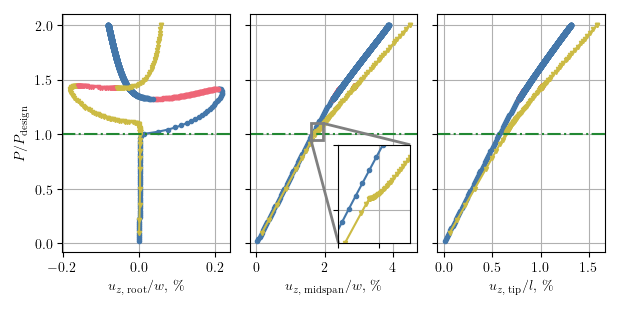

In [7]:
from resources import plot_utils

# Design labels
design_labels = ["initial structure", "linearly optimized structure"]

# Read eigenvalues, load and displacement histories for initial structure
key = design_labels[0]
initial_structure_directory_path = r"C:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model"
input_name = "sol_106_14976_elements_epsu1e-4"
f06_path = os.path.join(initial_structure_directory_path, input_name) + '.f06'  # path to .f06 file
eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
sol_106_op2_dict[key] = read_op2(os.path.join(initial_structure_directory_path, input_name) + '.op2', load_geometry=True, debug=None)
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2_dict[key], node_ids=plot_node_ids)
nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
displacements_dict[key] = displacements

# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*.5))
stable_lines = []
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Plot load-displacement diagrams
subcase_key_dict = {design_labels[0]: FIRST_SUBCASE_ID,
                    design_labels[1]: linear_opt_first_subcase_id}
reference_lengths = [W, W, L]  # reference lengths for nondimensionalization of displacements
for i, key in enumerate(design_labels):
    
    # Plot load vs displacement for each node
    for j, node_id in enumerate(plot_node_ids):
        plot_utils.plot_2d_load_displacements_stability(
            axes[j],
            displacements_dict[key][node_id][subcase_key_dict[key]][:, Z_COMPONENT_INDEX]/reference_lengths[j]*100,
            nondimensional_loads_dict[key],
            eigenvalues_dict[key],
            MARKERS[i], COLORS[i])
    
    # Create proxy artists for stable segments
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[i], color=COLORS[i], label=key))

# Plot linear buckling load line for optimized structure
for ax in axes:
    ax.axhline(y=1., color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for unstable segments
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling load")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{midspan}}/w$, \%")
axes[1].grid(visible=True)

# Set plot appearance for the second subplot
axes[2].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[2].grid(visible=True)

# Create zoomed inset in midspan displacement plot
x1, x2 = 1.6, 1.95  # x-interval of interest for the first zoomed inset
y1, y2 = .95, 1.1  # y-interval of interest for the first zoomed inset
axins = zoomed_inset_axes(axes[1], zoom=6., bbox_to_anchor=(-.12, .48), bbox_transform=ax.transAxes)
for i, key in enumerate(design_labels):
    plot_utils.plot_2d_load_displacements_stability(
        axins,
        displacements_dict[key][midspan_node_id][subcase_key_dict[key]][:, Z_COMPONENT_INDEX]/W*100,
        nondimensional_loads_dict[key],
        eigenvalues_dict[key],
        MARKERS[i], COLORS[i])
axins.set_xlim(x1, x2)  # Adjust the limits as needed
axins.set_ylim(y1, y2)    # Adjust the limits as needed
axins.tick_params(labelleft=False, labelbottom=False)
axins.grid(True)
mark_inset(axes[1], axins, loc1=3, loc2=1, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest

# Make legend
plt.tight_layout()  # Ensures proper spacing between subplots
fig.legend(handles=stable_lines + [unstable_line, glass_ceiling_line], ncols=2, bbox_to_anchor=(.76, 1.15), frameon=False)  # add legend after tight_layout

# Show and save plot
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TwoDesignVariableLinearOptLoadDisplacement.pdf"), bbox_inches='tight', pad_inches=0)

Compare applied load at first limit point.

In [8]:
# Find limit point load for each analysis
print("Limit point loads:")
first_neg_eig_index_dict = {}
limit_point_loads = {}
for key in design_labels:
    first_neg_eig_index_dict[key] = np.where(eigenvalues_dict[key][0] < 0)[0][0]  # find index of first negative eigenvalue
    limit_point_loads[key] = np.mean(
        nondimensional_loads_dict[key][first_neg_eig_index_dict[key] - 1:first_neg_eig_index_dict[key] + 1])  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load
    print(f"- {key}: {limit_point_loads[key]:.2f}")
    

Limit point loads:
- initial structure: 1.42
- linearly optimized structure: 1.44


Compare deformation under distributed non-follower forces vs non-follower forces applied to LRA under limit point load.

Deformation under initial structure


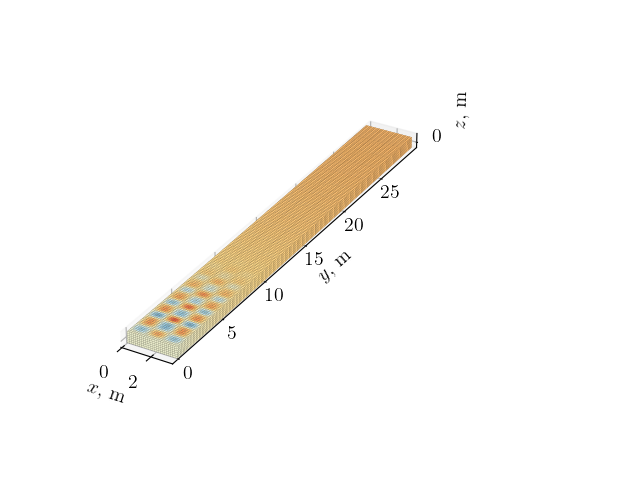

Deformation under linearly optimized structure


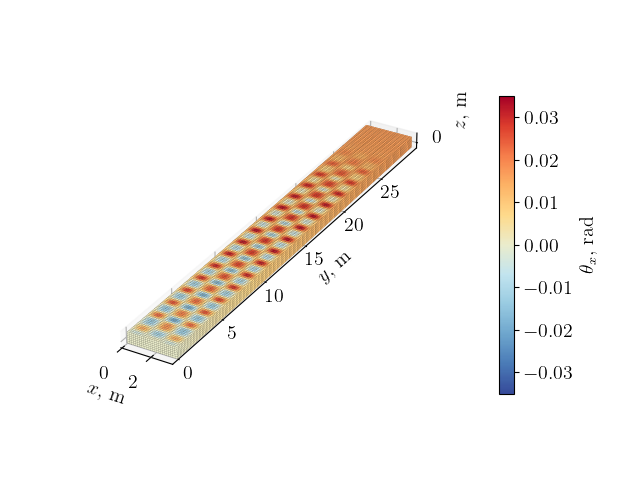

In [9]:
# Plot deformation under distributed non-follower forces
key = "initial structure"
print(f"Deformation under {key}")
clim = [-.035, .035]  # color limits for deformation plot
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_neg_eig_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
BBOX_NO_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"limit_point_deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_NO_COLORBAR,
            pad_inches=0)

# Plot deformation under non-follower forces applied to LRA
key = "linearly optimized structure"
print(f"Deformation under {key}")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=linear_opt_first_subcase_id, load_step=first_neg_eig_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"limit_point_deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Plot deformation at design load.

Deformation of initial structure


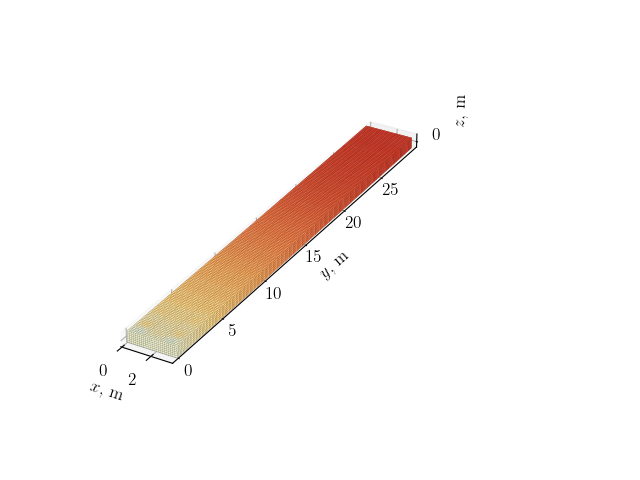

Deformation of linearly optimized structure


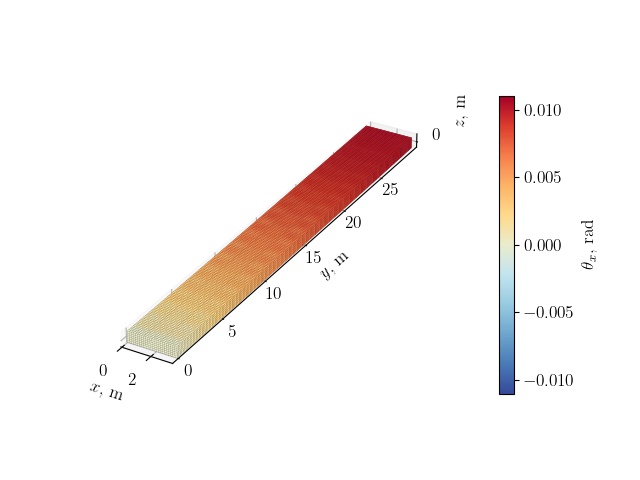

In [10]:
# Increase font size because figures will be side by side
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8})

# Plot deformation of initial structure
key = "initial structure"
print(f"Deformation of {key}")
design_load_index = np.argmin(np.abs(nondimensional_loads_dict[key] - 1))  # find index of design load
clim = [-.011, .011]
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, load_step=design_load_index + 1, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
bbox_no_colorbar = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"two_design_variable_{key.replace(' ', '_')}_deformation.pdf"),
            bbox_inches=bbox_no_colorbar, pad_inches=0)

# Plot deformation of nonlinearly optimized structure
key = "linearly optimized structure"
print(f"Deformation of {key}")
design_load_index = np.argmin(np.abs(nondimensional_loads_dict[key] - 1))  # find index of design load
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=linear_opt_first_subcase_id, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, load_step=design_load_index + 1, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
bbox_colorbar = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"two_design_variable_{key.replace(' ', '_')}_deformation_colorbar.pdf"),
            bbox_inches=bbox_colorbar, pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Plot nonlinear structural stability optimization history.

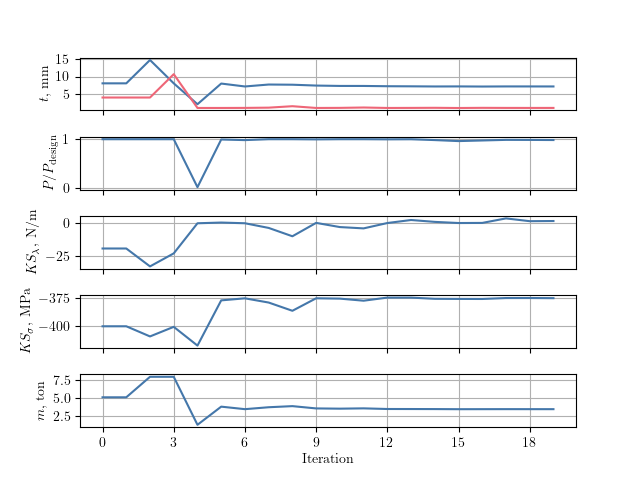

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.17151427 1.01151211]
- nastran_solver.applied_load: [0.98297636]
- nastran_solver.ks_stability: [1.911823]
- nastran_solver.ks_stress: [-375.40292358]
- nastran_solver.mass: [3.46412264]


In [11]:
recorder_filename = "sol_106_nonlinear_optimization.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TwoDesignVariableNonlinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Print mass reduction and final thickness distribution.

In [12]:
feasible_design_index = np.where(histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_reduction = (histories['nastran_solver.mass'][feasible_design_index, 0]/histories['nastran_solver.mass'][0, 0] - 1)*100
final_thickness_vector = histories['interp.t_cp'][feasible_design_index, :]
print("Final thickness vector:")
print(final_thickness_vector)
print(f"Mass reduction: {mass_reduction:.1f} %")

Final thickness vector:
[7.31739335 1.12910547]
Mass reduction: -30.0 %


Plot eigenvalue diagram of nonlinearly optimized structure.

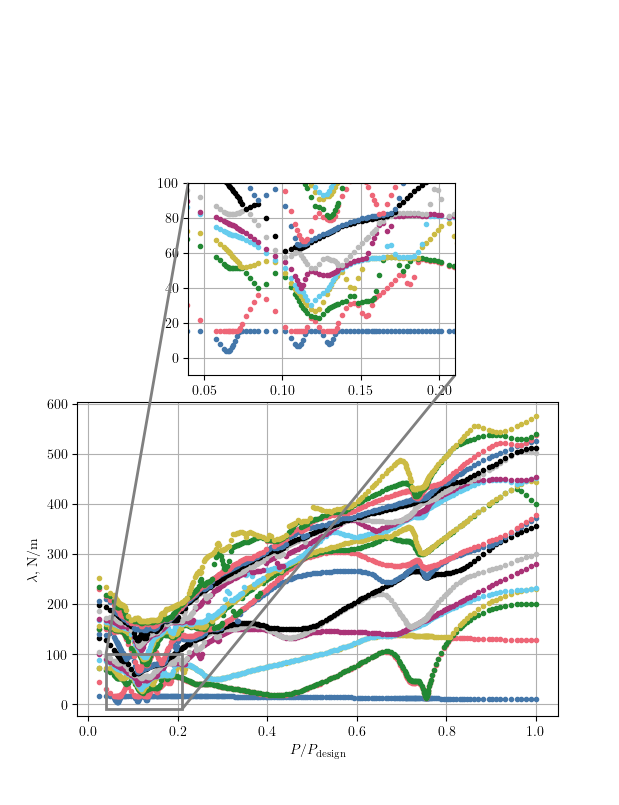

In [17]:
# Read eigenvalues, load and displacement histories for nonlinearly optimized structure
key = "nonlinearly optimized structure"
input_name = "sol_106_nonlinear_optimization_feasible"
f06_path = os.path.join(DATA_DIRECTORY_PATH, input_name) + '.f06'  # path to .f06 file
eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
sol_106_op2_dict[key] = read_op2(os.path.join(DATA_DIRECTORY_PATH, input_name) + '.op2', load_geometry=True, debug=None)
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2_dict[key], node_ids=plot_node_ids)
nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
displacements_dict[key] = displacements

# Create the figure
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*1.3))
fig.subplots_adjust(top=.5)

# Plot eigenvalues vs applied load
plt.plot(nondimensional_loads_dict[key], eigenvalues_dict[key].T*1e3, "o")  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda,\,\mathrm{N/m}$")
plt.xlabel("$P/P_\mathrm{design}$")
plt.grid(True)

# Create zoomed inset
x1, x2 = .04, .21  # x-interval of interest for the first zoomed inset
y1, y2 = -10, 100  # y-interval of interest for the first zoomed inset
axins = zoomed_inset_axes(ax, zoom=3.5, bbox_to_anchor=(.8, 1.72), bbox_transform=ax.transAxes)
axins.plot(nondimensional_loads_dict[key], eigenvalues_dict[key].T*1e3, "o")
axins.set_xlim(x1, x2)  # Adjust the limits as needed
axins.set_ylim(y1, y2)    # Adjust the limits as needed
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest
axins.grid(True)

# Adjust layout for better appearance
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadNonlinearOptEigenvalues.pdf"), bbox_inches='tight', pad_inches=0)

Plot load-displacement diagrams of the nonlinearly optimized CRM-like box beam in terms of $z$-displacement at the root, center, and tip.

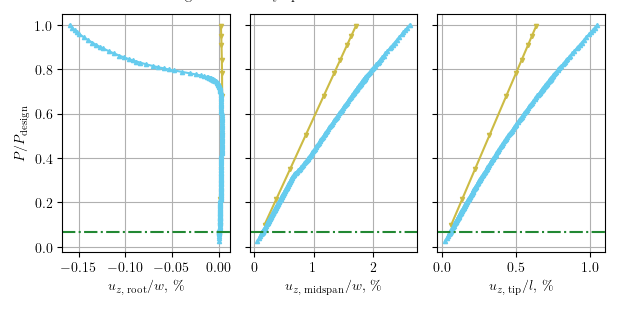

In [14]:
# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*.5))
stable_lines = []

# Plot load-displacement diagrams
design_labels = ["linearly optimized structure", "nonlinearly optimized structure"]
subcase_key_dict[design_labels[1]] = FIRST_SUBCASE_ID

for i, key in enumerate(design_labels):
    
    # Plot load vs displacement for each node
    for j, node_id in enumerate(plot_node_ids):
        plot_indices = nondimensional_loads_dict[key] <= 1.  # plot only up to design load
        plot_utils.plot_2d_load_displacements_stability(
            axes[j],
            displacements_dict[key][node_id][subcase_key_dict[key]][plot_indices, Z_COMPONENT_INDEX]/reference_lengths[j]*100,
            nondimensional_loads_dict[key][plot_indices],
            eigenvalues_dict[key][:, plot_indices],
            MARKERS[i + 1], COLORS[i + 1])
    
    # Create proxy artists for stable segments
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[i + 1], color=COLORS[i + 1], label=key))

# Plot linear buckling load line for optimized structure
sol_105_op2 = read_op2(os.path.join(DATA_DIRECTORY_PATH, "sol_105_nonlinear_optimization_feasible.op2"), load_geometry=True, debug=None)
linear_buckling_load = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
for ax in axes:
    ax.axhline(y=linear_buckling_load, color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for unstable segments
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{midspan}}/w$, \%")
axes[1].grid(visible=True)

# Set plot appearance for the second subplot
axes[2].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[2].grid(visible=True)

# Make legend
plt.tight_layout()  # Ensures proper spacing between subplots
fig.legend(handles=stable_lines + [glass_ceiling_line], bbox_to_anchor=(.67, 1.2), frameon=False)  # add legend after tight_layout

# Show and save plot
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TwoDesignVariableNonlinearOptLoadDisplacement.pdf"), bbox_inches='tight', pad_inches=0)

Plot deformation of linearly vs nonlinearly optimized structure at design load.

Deformation of linearly optimized structure


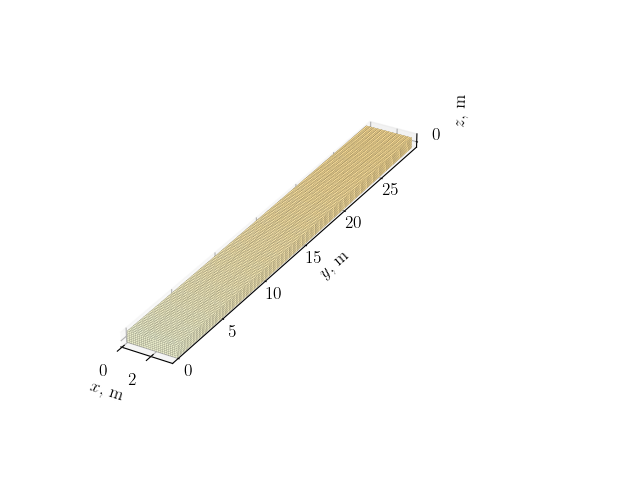

Deformation of nonlinearly optimized structure


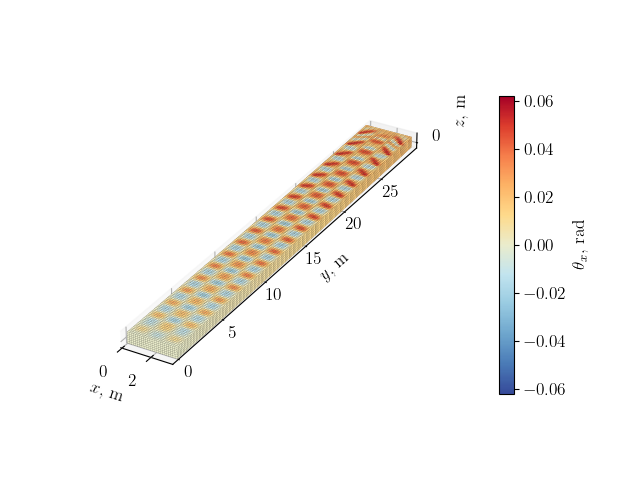

In [15]:
# Increase font size because figures will be side by side
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8})

# Plot deformation of initial structure
key = "linearly optimized structure"
print(f"Deformation of {key}")
design_load_index = np.argmin(np.abs(nondimensional_loads_dict[key] - 1))  # find index of design load
clim = [-.062, .062]
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=linear_opt_first_subcase_id, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, load_step=design_load_index + 1, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"two_design_variable_{key.replace(' ', '_')}_deformation.pdf"),
            bbox_inches=bbox_no_colorbar, pad_inches=0)

# Plot deformation of nonlinearly optimized structure
key = "nonlinearly optimized structure"
print(f"Deformation of {key}")
design_load_index = np.argmin(np.abs(nondimensional_loads_dict[key] - 1))  # find index of design load
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, load_step=design_load_index + 1, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"two_design_variable_{key.replace(' ', '_')}_deformation.pdf"),
            bbox_inches=bbox_colorbar, pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})